In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path_2 = './part_2'

## Initial Data Load

In [50]:
assets = pd.read_csv(path_2 + '/assets.csv')
collects = pd.read_csv(path_2 + '/collects.csv')

In [51]:
assets['sensors'] = assets['sensors'].str[2:-2]
assets = assets.rename(columns={'sensors':'sensorId'})
assets.head()

,_id,company,createdAt,description,model,modelType,name,sensorId,specifications.axisX,specifications.axisY,specifications.axisZ,specifications.maxDowntime,specifications.maxTemp,specifications.power,specifications.rpm,specifications.workdays
0,602fac7228aba1048d473cc4,5fb2c4eb1369a4325dc4545f,2021-02-19T12:17:54.457Z,NaN,60241102ed8ef30e9d309af9,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,IAJ9206,vertical,horizontal,axial,48.00,NaN,3.7,1735.0,NaN
1,5fd0e297bf7d581c1823b8e4,5fbbadeb82a6b901c26df618,2020-12-09T14:43:35.168Z,NaN,5fd0cf96bf7d581c1823b4c4,heaterFurnace,RDF-61.1,LZY4270,axial,vertical,horizontal,0.25,55.0,0.0,1740.0,NaN
2,5fb286de1369a4325dc45433,5f6b83e34dd69d4bc799ea1f,2020-11-16T14:04:14.564Z,-,5fb275981369a4325dc4542e,transformer,TRANSFORMADOR 500 KVA N°1,MUR8453,horizontal,vertical,NaN,NaN,65.0,NaN,NaN,NaN
3,6023fad9ed8ef30e9d30952b,5fb2c4eb1369a4325dc4545f,2021-02-10T15:25:13.265Z,NaN,6023f7dced8ef30e9d30945f,pump,Motor Bomba - Tanque de Expansão Tubo Verde,MXK6435,horizontal,axial,vertical,48.00,NaN,7.0,3525.0,NaN
4,5ff71a150b6abb7be05083b0,5f17203f640a00cc08cb1b3d,2021-01-07T14:26:29.726Z,NaN,5ff5a854adacd8372cf06950,pump,CAG1- BAGS.12- Motor,MYD8706,horizontal,axial,vertical,NaN,NaN,30.0,1765.0,NaN


In [52]:
assets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   _id                         10 non-null     object 
 1   company                     10 non-null     object 
 2   createdAt                   10 non-null     object 
 3   description                 3 non-null      object 
 4   model                       10 non-null     object 
 5   modelType                   10 non-null     object 
 6   name                        10 non-null     object 
 7   sensorId                    10 non-null     object 
 8   specifications.axisX        8 non-null      object 
 9   specifications.axisY        8 non-null      object 
 10  specifications.axisZ        7 non-null      object 
 11  specifications.maxDowntime  6 non-null      float64
 12  specifications.maxTemp      5 non-null      float64
 13  specifications.power        8 non-null

In [53]:
collects = collects.rename(columns={'createdAt':'created'})
collects['created'] = pd.to_datetime(collects['created'])
collects.head()

,_id,created,params.accelRMS.x,params.accelRMS.y,params.accelRMS.z,params.duration,params.sampRate,params.timeStart,params.velRMS.x,params.velRMS.y,params.velRMS.z,sensorId,temp
0,60b57955f77013684c413e39,2021-06-01 00:03:33.370000+00:00,0.010463,0.004463,0.011677,3.006,1656.686627,1.622506e+09,0.000511,0.000176,0.000289,IAJ9206,23.94
1,60b57c53f77013684c41409f,2021-06-01 00:16:19.173000+00:00,0.011437,0.004983,0.011482,3.006,1656.686627,1.622507e+09,0.000633,0.000238,0.000292,IAJ9206,23.19
2,60b57f34f77013684c4142cd,2021-06-01 00:28:36.553000+00:00,0.010494,0.005024,0.011120,3.006,1656.686627,1.622507e+09,0.000524,0.000226,0.000246,IAJ9206,22.50
3,60b58237f77013684c41450c,2021-06-01 00:41:27.622000+00:00,0.009859,0.004786,0.011096,3.006,1656.686627,1.622508e+09,0.000437,0.000220,0.000248,IAJ9206,22.87
4,60b58515f77013684c414765,2021-06-01 00:53:41.450000+00:00,0.010014,0.005213,0.011332,3.006,1656.686627,1.622509e+09,0.000501,0.000251,0.000275,IAJ9206,22.56


In [54]:
collects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33901 entries, 0 to 33900
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   _id                33901 non-null  object             
 1   created            33901 non-null  datetime64[ns, UTC]
 2   params.accelRMS.x  33441 non-null  float64            
 3   params.accelRMS.y  33441 non-null  float64            
 4   params.accelRMS.z  33441 non-null  float64            
 5   params.duration    33441 non-null  float64            
 6   params.sampRate    33441 non-null  float64            
 7   params.timeStart   33441 non-null  float64            
 8   params.velRMS.x    33441 non-null  float64            
 9   params.velRMS.y    33441 non-null  float64            
 10  params.velRMS.z    33441 non-null  float64            
 11  sensorId           33901 non-null  object             
 12  temp               33901 non-null  float64    

In [55]:
print(assets['sensorId'].unique())
print(collects['sensorId'].unique())

['IAJ9206' 'LZY4270' 'MUR8453' 'MXK6435' 'MYD8706' 'MYS2071' 'MZU6388'
 'NAH4736' 'NAI1549' 'NEW4797']
['IAJ9206' 'LZY4270' 'MUR8453' 'MXK6435' 'MYD8706' 'MYS2071' 'MZU6388'
 'NAH4736' 'NAI1549' 'NEW4797']


In [56]:
full_df = collects.merge(assets, how='left', on='sensorId')
full_df.head()

,_id_x,created,params.accelRMS.x,params.accelRMS.y,params.accelRMS.z,params.duration,params.sampRate,params.timeStart,params.velRMS.x,params.velRMS.y,...,modelType,name,specifications.axisX,specifications.axisY,specifications.axisZ,specifications.maxDowntime,specifications.maxTemp,specifications.power,specifications.rpm,specifications.workdays
0,60b57955f77013684c413e39,2021-06-01 00:03:33.370000+00:00,0.010463,0.004463,0.011677,3.006,1656.686627,1.622506e+09,0.000511,0.000176,...,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.0,NaN,3.7,1735.0,NaN
1,60b57c53f77013684c41409f,2021-06-01 00:16:19.173000+00:00,0.011437,0.004983,0.011482,3.006,1656.686627,1.622507e+09,0.000633,0.000238,...,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.0,NaN,3.7,1735.0,NaN
2,60b57f34f77013684c4142cd,2021-06-01 00:28:36.553000+00:00,0.010494,0.005024,0.011120,3.006,1656.686627,1.622507e+09,0.000524,0.000226,...,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.0,NaN,3.7,1735.0,NaN
3,60b58237f77013684c41450c,2021-06-01 00:41:27.622000+00:00,0.009859,0.004786,0.011096,3.006,1656.686627,1.622508e+09,0.000437,0.000220,...,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.0,NaN,3.7,1735.0,NaN
4,60b58515f77013684c414765,2021-06-01 00:53:41.450000+00:00,0.010014,0.005213,0.011332,3.006,1656.686627,1.622509e+09,0.000501,0.000251,...,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.0,NaN,3.7,1735.0,NaN


## Organizing assets data

In [99]:
class Asset:
    def __init__(self, df, row):
        self.sensorID = row['sensorId']
        self.company = row['company']
        self.description = row['description']
        self.model = row['model']
        self.modelType = row['modelType']
        self.name = row['name']
        self.axisX = row['specifications.axisX']
        self.axisY = row['specifications.axisY']
        self.axisZ = row['specifications.axisZ']
        self.maxDowntime = row['specifications.maxDowntime']
        self.maxTemp = row['specifications.maxTemp']
        self.power = row['specifications.power']
        self.rpm = row['specifications.rpm']
        self.power = row['specifications.power']
        self.workdays = row['specifications.workdays']
        
        self.df = self.setData(df)

        self.calcDownTime()

    def setData(self, df):
        df = df[df['sensorId'] == self.sensorID].sort_values(by='created')
        df['delta_created'] = df['created'].diff(-1)
        df['delta_created'] = df['delta_created'].dt.total_seconds()*-1
        df['time_s'] = df['created']-df['created'].min()
        df['time_s'] = df['time_s'].dt.total_seconds()
        df['time_s_2'] = df['params.timeStart'] - df['params.timeStart'].min()
        df[[
            'params.accelRMS.x',
            'params.accelRMS.y',
            'params.accelRMS.z',
            'params.velRMS.x',
            'params.velRMS.y',
            'params.velRMS.z']] =df[[
            'params.accelRMS.x',
            'params.accelRMS.y',
            'params.accelRMS.z',
            'params.velRMS.x',
            'params.velRMS.y',
            'params.velRMS.z'
            ]].fillna(-0.01)
        df['time_s_3'] = df['time_s_2']
        df['time_s_2'] = df['time_s_2'].fillna(df['time_s'])
        df = df.reset_index(drop=True)
        return df
    
    def calcDownTime(self):
        down_df = self.df.iloc[:-1] # excluir primeira linha, pois não tem delta
        down_df = down_df[(down_df['time_s_3'].isnull())]
        print('{} downtime: {:.0f} ms'.format(self.name, down_df['delta_created'].sum()))


In [100]:
mach = list(assets['sensorId'].unique())
data = {}

for idx, row in assets.iterrows():
    data[row['sensorId']] = Asset(full_df, row)

Ventilador Acima do Elemento GA160 FF - Prédio B015 downtime: 45574 ms
RDF-61.1 downtime: 43801 ms
TRANSFORMADOR 500 KVA N°1 downtime: 42524 ms
Motor Bomba - Tanque de Expansão Tubo Verde   downtime: 45820 ms
CAG1- BAGS.12- Motor downtime: 45632 ms
VTF-61.1 downtime: 44830 ms
Boko MA-1510 - Motor 2 da UH downtime: 698 ms
Ventilador -GA75 FF - Prédio B104 downtime: 0 ms
CAG1- BAGS.3- Motor  downtime: 45367 ms
ROTULADORA SIDEL  downtime: 44953 ms


<Axes: xlabel='time_s_2', ylabel='params.accelRMS.x'>

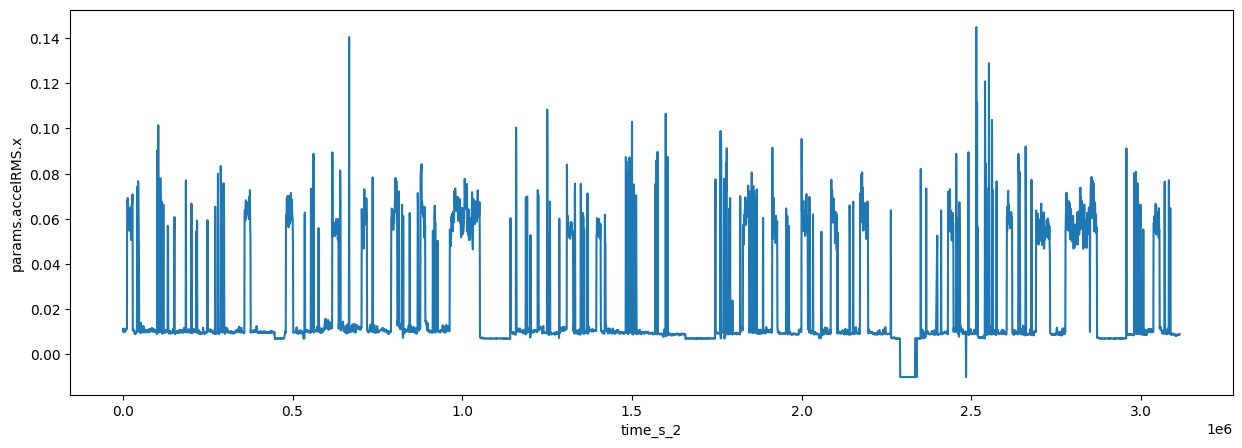

In [101]:
data['IAJ9206'].df

fig, axes = plt.subplots(1, 1, figsize=(15, 5), sharey=False)
sns.lineplot(data['IAJ9206'].df, x='time_s_2', y='params.accelRMS.x', ax=axes)

In [85]:
aux = data['IAJ9206'].df
aux[aux['time_s_2'].isnull()]
# aux.iloc[1:]
aux

,_id_x,created,params.accelRMS.x,params.accelRMS.y,params.accelRMS.z,params.duration,params.sampRate,params.timeStart,params.velRMS.x,params.velRMS.y,...,specifications.axisZ,specifications.maxDowntime,specifications.maxTemp,specifications.power,specifications.rpm,specifications.workdays,delta_created,time_s,time_s_2,time_s_3
0,60b57955f77013684c413e39,2021-06-01 00:03:33.370000+00:00,0.010463,0.004463,0.011677,3.006,1656.686627,1.622506e+09,0.000511,0.000176,...,axial,48.0,NaN,3.7,1735.0,NaN,765.803,0.000,0.0,0.0
1,60b57c53f77013684c41409f,2021-06-01 00:16:19.173000+00:00,0.011437,0.004983,0.011482,3.006,1656.686627,1.622507e+09,0.000633,0.000238,...,axial,48.0,NaN,3.7,1735.0,NaN,737.380,765.803,766.0,766.0
2,60b57f34f77013684c4142cd,2021-06-01 00:28:36.553000+00:00,0.010494,0.005024,0.011120,3.006,1656.686627,1.622507e+09,0.000524,0.000226,...,axial,48.0,NaN,3.7,1735.0,NaN,771.069,1503.183,1503.0,1503.0
3,60b58237f77013684c41450c,2021-06-01 00:41:27.622000+00:00,0.009859,0.004786,0.011096,3.006,1656.686627,1.622508e+09,0.000437,0.000220,...,axial,48.0,NaN,3.7,1735.0,NaN,733.828,2274.252,2275.0,2275.0
4,60b58515f77013684c414765,2021-06-01 00:53:41.450000+00:00,0.010014,0.005213,0.011332,3.006,1656.686627,1.622509e+09,0.000501,0.000251,...,axial,48.0,NaN,3.7,1735.0,NaN,732.857,3008.080,3008.0,3008.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3981,60e4f26935645405b62ea5fb,2021-07-07 00:16:41.693000+00:00,0.008619,0.004223,0.011166,3.006,1656.686627,1.625617e+09,0.000179,0.000110,...,axial,48.0,NaN,3.7,1735.0,NaN,762.262,3111188.323,3111189.0,3111189.0
3982,60e4f56335645405b62ea82a,2021-07-07 00:29:23.955000+00:00,0.008664,0.004379,0.011025,3.006,1656.686627,1.625618e+09,0.000184,0.000124,...,axial,48.0,NaN,3.7,1735.0,NaN,769.416,3111950.585,3111951.0,3111951.0
3983,60e4f86535645405b62eaa44,2021-07-07 00:42:13.371000+00:00,0.008754,0.004327,0.011052,3.006,1656.686627,1.625619e+09,0.000183,0.000106,...,axial,48.0,NaN,3.7,1735.0,NaN,753.720,3112720.001,3112720.0,3112720.0
3984,60e4fb5735645405b62eac5c,2021-07-07 00:54:47.091000+00:00,0.008704,0.004497,0.011002,3.006,1656.686627,1.625619e+09,0.000190,0.000144,...,axial,48.0,NaN,3.7,1735.0,NaN,730.884,3113473.721,3113474.0,3113474.0


In [87]:
assets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   _id                         10 non-null     object 
 1   company                     10 non-null     object 
 2   createdAt                   10 non-null     object 
 3   description                 3 non-null      object 
 4   model                       10 non-null     object 
 5   modelType                   10 non-null     object 
 6   name                        10 non-null     object 
 7   sensorId                    10 non-null     object 
 8   specifications.axisX        8 non-null      object 
 9   specifications.axisY        8 non-null      object 
 10  specifications.axisZ        7 non-null      object 
 11  specifications.maxDowntime  6 non-null      float64
 12  specifications.maxTemp      5 non-null      float64
 13  specifications.power        8 non-null